In [1]:

# hard to compute/long time

import torch
import random
import numpy as np
import itertools
from typing import List, Tuple, Dict, Callable
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LogicalOperation:
    def __init__(self, operation: str, coordinate: Tuple[float, float, float], inputs: List[int]):
        self.operation = operation
        self.coordinate = coordinate
        self.inputs = inputs
        self.output = None

class Circuit:
    def __init__(self, operations: List[LogicalOperation], input_map: Dict[int, bool]):
        self.operations = operations
        self.input_map = input_map
        self.fitness = 0.0

class SyntheticAI:
    def __init__(self, population_size: int = 100, mutation_rate: float = 0.1):
        self.encoding_ability = torch.tensor([0.0], device=device)
        self.decoding_ability = torch.tensor([0.0], device=device)
        self.logical_ability = torch.tensor([0.0], device=device)
        self.operation_regions = self._initialize_operation_regions()
        self.population_size = population_size
        self.mutation_rate = mutation_rate

    def _initialize_operation_regions(self):
        return {
            "AND": torch.rand(3, device=device),
            "OR": torch.rand(3, device=device),
            "NOT": torch.rand(3, device=device),
            "XOR": torch.rand(3, device=device),
            "NAND": torch.rand(3, device=device),
            "NOR": torch.rand(3, device=device)
        }

    def train(self):
        self.encoding_ability += torch.rand(1, device=device) * 0.01
        self.decoding_ability += torch.rand(1, device=device) * 0.01
        self.logical_ability += torch.rand(1, device=device) * 0.01

        for op in self.operation_regions:
            self.operation_regions[op] += torch.randn(3, device=device) * 0.01
            self.operation_regions[op] = torch.clamp(self.operation_regions[op], 0, 1)

    def calculate_operation_affinity(self, operation, coordinate):
        op_region = self.operation_regions[operation]
        coordinate_tensor = torch.tensor(coordinate, device=device)
        distance = torch.norm(op_region - coordinate_tensor)
        affinity = 1 / (1 + distance)
        return affinity.item()

    def execute_operation(self, logical_op: LogicalOperation, circuit: Circuit) -> bool:
        affinity = self.calculate_operation_affinity(logical_op.operation, logical_op.coordinate)
        adjusted_ability = self.logical_ability * (0.5 + affinity)

        input_values = [circuit.input_map[i] if i in circuit.input_map else circuit.operations[i].output for i in logical_op.inputs]

        if logical_op.operation == "AND":
            result = all(input_values)
        elif logical_op.operation == "OR":
            result = any(input_values)
        elif logical_op.operation == "NOT":
            result = not input_values[0]
        elif logical_op.operation == "XOR":
            result = sum(input_values) % 2 == 1
        elif logical_op.operation == "NAND":
            result = not all(input_values)
        elif logical_op.operation == "NOR":
            result = not any(input_values)
        else:
            raise ValueError(f"Unknown operation: {logical_op.operation}")

        error = torch.rand(1, device=device) * (1 - adjusted_ability)
        return (result + error.item()) > 0.5

    def evaluate_circuit(self, circuit: Circuit, inputs: List[bool]) -> bool:
        circuit.input_map = {i: inputs[i] for i in range(len(inputs))}
        for op in circuit.operations:
            op.output = self.execute_operation(op, circuit)
        return circuit.operations[-1].output

    def generate_random_circuit(self, num_operations: int, num_inputs: int) -> Circuit:
        operations = []
        input_map = {i: False for i in range(num_inputs)}  # Initialize with False
        for i in range(num_operations):
            op = random.choice(list(self.operation_regions.keys()))
            coord = tuple(random.random() for _ in range(3))
            if i == 0:
                inputs = [random.randint(0, num_inputs-1) for _ in range(2)]
            else:
                inputs = [random.randint(0, i-1) for _ in range(2)]
            operations.append(LogicalOperation(op, coord, inputs))
        return Circuit(operations, input_map)

    def mutate_circuit(self, circuit: Circuit) -> Circuit:
        new_operations = []
        for i, op in enumerate(circuit.operations):
            if random.random() < self.mutation_rate:
                new_op = random.choice(list(self.operation_regions.keys()))
                new_coord = tuple(random.random() for _ in range(3))
                new_inputs = [random.randint(0, i-1) for _ in range(2)] if i > 0 else [random.randint(0, len(circuit.input_map)-1) for _ in range(2)]
                new_operations.append(LogicalOperation(new_op, new_coord, new_inputs))
            else:
                new_operations.append(op)
        return Circuit(new_operations, circuit.input_map.copy())

    def crossover(self, parent1: Circuit, parent2: Circuit) -> Circuit:
        split_point = random.randint(1, len(parent1.operations) - 1)
        child_operations = parent1.operations[:split_point] + parent2.operations[split_point:]
        child_input_map = parent1.input_map.copy()
        return Circuit(child_operations, child_input_map)

    def evolve_circuit(self, target_function: Callable, generations: int = 500, num_operations: int = 30, num_inputs: int = 8):
        def fitness(circuit):
            correct_outputs = sum(self.evaluate_circuit(circuit, list(inputs)) == target_function(inputs)
                                  for inputs in itertools.product([False, True], repeat=num_inputs))
            efficiency = 1 / (len(circuit.operations) + 1)  # Prefer shorter circuits
            diversity = len(set(op.operation for op in circuit.operations)) / len(self.operation_regions)  # Reward diverse operations
            return (correct_outputs / 2**num_inputs) * 0.7 + efficiency * 0.2 + diversity * 0.1

        population = [self.generate_random_circuit(num_operations, num_inputs) for _ in range(self.population_size)]

        best_fitnesses = []

        for generation in range(generations):
            for circuit in population:
                circuit.fitness = fitness(circuit)

            population.sort(key=lambda x: x.fitness, reverse=True)
            best_circuit = population[0]
            best_fitnesses.append(best_circuit.fitness)

            if best_circuit.fitness >= 0.99:  # Allow for small errors due to probabilistic nature
                print(f"Solution found in generation {generation}")
                self.plot_fitness_evolution(best_fitnesses)
                return best_circuit

            new_population = population[:self.population_size // 2]  # Keep top half

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(population[:self.population_size // 2], 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate_circuit(child)
                new_population.append(child)

            population = new_population

            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_circuit.fitness}")

        print("No perfect solution found, returning best circuit")
        self.plot_fitness_evolution(best_fitnesses)
        return population[0]

    def plot_fitness_evolution(self, fitnesses):
        plt.figure(figsize=(10, 6))
        plt.plot(fitnesses)
        plt.title('Evolution of Best Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()

# Example usage
ai = SyntheticAI()

# Train the AI
for _ in range(100):
    ai.train()

# Define a complex target function
def target_function(inputs):
    # Example: Implement a complex 8-input function
    return (inputs[0] and inputs[1]) or (inputs[2] and not inputs[3]) or (inputs[4] ^ inputs[5]) or (inputs[6] and inputs[7])

# Evolve a circuit for the target function
best_circuit = ai.evolve_circuit(target_function, generations=500, num_operations=30, num_inputs=8)

print("\nBest circuit found:")
for i, op in enumerate(best_circuit.operations):
    print(f"Step {i+1}: {op.operation} at {op.coordinate}, inputs: {op.inputs}")

print(f"\nFinal fitness: {best_circuit.fitness}")
print(f"Logical ability: {ai.logical_ability.item():.4f}")

# Test the best circuit
print("\nTesting the best circuit:")
for inputs in itertools.product([False, True], repeat=8):
    circuit_output = ai.evaluate_circuit(best_circuit, list(inputs))
    expected_output = target_function(inputs)
    print(f"Inputs: {inputs}, Circuit Output: {circuit_output}, Expected Output: {expected_output}")

Using device: cuda


KeyboardInterrupt: 

Using device: cuda
Generation 0: Best fitness = 0.75
Generation 10: Best fitness = 0.8125
Generation 20: Best fitness = 0.8125
Generation 30: Best fitness = 0.8125
Generation 40: Best fitness = 0.8125
Generation 50: Best fitness = 0.8125
Generation 60: Best fitness = 0.9375
Generation 70: Best fitness = 0.9375
Generation 80: Best fitness = 0.9375
Generation 90: Best fitness = 0.9375
Perfect solution found in generation 96


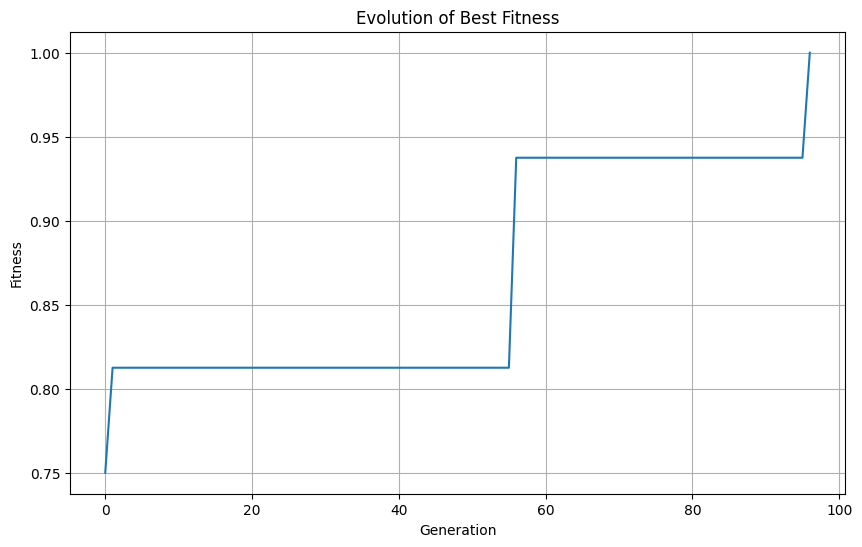


Best circuit found:
Step 1: OR at (0.7043169908729119, 0.2557241398899146, 0.37238930232328205), inputs: [2, 1]
Step 2: OR at (0.7726350885950352, 0.29413319955005335, 0.5623393340316049), inputs: [0, 0]
Step 3: NOT at (0.8210105313549528, 0.5797094791262193, 0.43393274678552296), inputs: [0, 1]
Step 4: NOT at (0.4628824741187898, 0.0015829610731403765, 0.20342297086664285), inputs: [2, 1]
Step 5: OR at (0.2697728130648739, 0.630745615578776, 0.7858786722116374), inputs: [1, 3]
Step 6: AND at (0.8754529259948158, 0.5035206933043263, 0.6747069895474789), inputs: [3, 2]
Step 7: AND at (0.8723092445789468, 0.9831267842546245, 0.5252817471848144), inputs: [4, 5]
Step 8: AND at (0.35485443796219185, 0.595020794802397, 0.7885944638673364), inputs: [1, 0]
Step 9: NOT at (0.8694288728992982, 0.8156134269040017, 0.8976494361949625), inputs: [5, 6]
Step 10: OR at (0.3913395579891299, 0.3695141868942221, 0.009663151799672254), inputs: [7, 6]

Final fitness: 1.0
Logical ability: 1.0000

Testing t

In [4]:
import torch
import random
import numpy as np
import itertools
from typing import List, Tuple, Dict, Callable
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LogicalOperation:
    def __init__(self, operation: str, coordinate: Tuple[float, float, float], inputs: List[int]):
        self.operation = operation
        self.coordinate = coordinate
        self.inputs = inputs
        self.output = None

class Circuit:
    def __init__(self, operations: List[LogicalOperation], input_map: Dict[int, bool]):
        self.operations = operations
        self.input_map = input_map
        self.fitness = 0.0

class SyntheticAI:
    def __init__(self, population_size: int = 50, mutation_rate: float = 0.2):
        self.logical_ability = torch.tensor([0.0], device=device)
        self.operation_regions = self._initialize_operation_regions()
        self.population_size = population_size
        self.mutation_rate = mutation_rate

    def _initialize_operation_regions(self):
        return {
            "AND": torch.rand(3, device=device),
            "OR": torch.rand(3, device=device),
            "NOT": torch.rand(3, device=device),
            "XOR": torch.rand(3, device=device)
        }

    def train(self):
        self.logical_ability += torch.rand(1, device=device) * 0.01
        self.logical_ability = torch.clamp(self.logical_ability, 0, 1)

    def calculate_operation_affinity(self, operation, coordinate):
        op_region = self.operation_regions[operation]
        coordinate_tensor = torch.tensor(coordinate, device=device)
        distance = torch.norm(op_region - coordinate_tensor)
        affinity = 1 / (1 + distance)
        return affinity.item()

    def execute_operation(self, logical_op: LogicalOperation, circuit: Circuit) -> bool:
        affinity = self.calculate_operation_affinity(logical_op.operation, logical_op.coordinate)
        adjusted_ability = self.logical_ability * (0.5 + affinity)

        input_values = [circuit.input_map[i] if i in circuit.input_map else circuit.operations[i].output for i in logical_op.inputs]

        if logical_op.operation == "AND":
            result = all(input_values)
        elif logical_op.operation == "OR":
            result = any(input_values)
        elif logical_op.operation == "NOT":
            result = not input_values[0]
        elif logical_op.operation == "XOR":
            result = input_values[0] ^ input_values[1]
        else:
            raise ValueError(f"Unknown operation: {logical_op.operation}")

        error = torch.rand(1, device=device) * (1 - adjusted_ability)
        return (result + error.item()) > 0.5

    def evaluate_circuit(self, circuit: Circuit, inputs: List[bool]) -> bool:
        circuit.input_map = {i: inputs[i] for i in range(len(inputs))}
        for op in circuit.operations:
            op.output = self.execute_operation(op, circuit)
        return circuit.operations[-1].output

    def generate_random_circuit(self, num_operations: int, num_inputs: int) -> Circuit:
        operations = []
        input_map = {i: False for i in range(num_inputs)}
        for i in range(num_operations):
            op = random.choice(list(self.operation_regions.keys()))
            coord = tuple(random.random() for _ in range(3))
            if i == 0:
                inputs = [random.randint(0, num_inputs-1) for _ in range(2)]
            else:
                inputs = [random.randint(0, i-1) for _ in range(2)]
            operations.append(LogicalOperation(op, coord, inputs))
        return Circuit(operations, input_map)

    def mutate_circuit(self, circuit: Circuit) -> Circuit:
        new_operations = []
        for i, op in enumerate(circuit.operations):
            if random.random() < self.mutation_rate:
                new_op = random.choice(list(self.operation_regions.keys()))
                new_coord = tuple(random.random() for _ in range(3))
                new_inputs = [random.randint(0, i-1) for _ in range(2)] if i > 0 else [random.randint(0, len(circuit.input_map)-1) for _ in range(2)]
                new_operations.append(LogicalOperation(new_op, new_coord, new_inputs))
            else:
                new_operations.append(op)
        return Circuit(new_operations, circuit.input_map.copy())

    def crossover(self, parent1: Circuit, parent2: Circuit) -> Circuit:
        split_point = random.randint(1, len(parent1.operations) - 1)
        child_operations = parent1.operations[:split_point] + parent2.operations[split_point:]
        child_input_map = parent1.input_map.copy()
        return Circuit(child_operations, child_input_map)

    def evolve_circuit(self, target_function: Callable, generations: int = 100, num_operations: int = 10, num_inputs: int = 4):
        def fitness(circuit):
            correct_outputs = sum(self.evaluate_circuit(circuit, list(inputs)) == target_function(inputs)
                                  for inputs in itertools.product([False, True], repeat=num_inputs))
            return correct_outputs / 2**num_inputs

        population = [self.generate_random_circuit(num_operations, num_inputs) for _ in range(self.population_size)]

        best_fitnesses = []

        for generation in range(generations):
            for circuit in population:
                circuit.fitness = fitness(circuit)

            population.sort(key=lambda x: x.fitness, reverse=True)
            best_circuit = population[0]
            best_fitnesses.append(best_circuit.fitness)

            if best_circuit.fitness == 1.0:
                print(f"Perfect solution found in generation {generation}")
                self.plot_fitness_evolution(best_fitnesses)
                return best_circuit

            new_population = population[:self.population_size // 2]  # Keep top half

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(population[:self.population_size // 2], 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate_circuit(child)
                new_population.append(child)

            population = new_population

            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_circuit.fitness}")

        print("No perfect solution found, returning best circuit")
        self.plot_fitness_evolution(best_fitnesses)
        return population[0]

    def plot_fitness_evolution(self, fitnesses):
        plt.figure(figsize=(10, 6))
        plt.plot(fitnesses)
        plt.title('Evolution of Best Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()

# Example usage
ai = SyntheticAI()

# Train the AI
for _ in range(1000):
    ai.train()

# Define a simpler target function
def target_function(inputs):
    return (inputs[0] and inputs[1]) or (inputs[2] and inputs[3])

# Evolve a circuit for the target function
best_circuit = ai.evolve_circuit(target_function, generations=100, num_operations=10, num_inputs=4)

print("\nBest circuit found:")
for i, op in enumerate(best_circuit.operations):
    print(f"Step {i+1}: {op.operation} at {op.coordinate}, inputs: {op.inputs}")

print(f"\nFinal fitness: {best_circuit.fitness}")
print(f"Logical ability: {ai.logical_ability.item():.4f}")

# Test the best circuit
print("\nTesting the best circuit:")
for inputs in itertools.product([False, True], repeat=4):
    circuit_output = ai.evaluate_circuit(best_circuit, list(inputs))
    expected_output = target_function(inputs)
    print(f"Inputs: {inputs}, Circuit Output: {circuit_output}, Expected Output: {expected_output}")